# TODO:
1. Simplify code
2. experiment of within tissue normalization. (or knn normalization across cells, or metacell ideas)
3. check what makes the difference between earlier implementation and this implementation. (a) increased permutation (b) subtracting the mean (c) homologs as background permutations
4. new data, droplet / human lung atlas
5. Downstream applications.
6. Re-evaluate genesets
7. Question: how does FDR cope with correlated p-values?

In [1]:
# data
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp

# system
import os
import time
from os.path import join

# stats
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import itertools
from gprofiler import GProfiler
import submitit
import itertools

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

from scTRS.method import get_p_from_empi_null
# gene_score should go utils
from IPython.display import Markdown, display


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.2 scipy==1.5.2 pandas==1.1.2 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.3 leidenalg==0.8.2


In [2]:
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
GENE_SCORE_PATH = join(DATA_PATH, 'trs_gene_scores')
hsapiens_mmusculus_mapping = pd.read_csv(join(GENE_SCORE_PATH, 'meta_data', 'hsapiens_mmusculus_mapping.csv'))

dic_data_facs = dl.load_tms_processed(DATA_PATH, data_name='facs', tissue='all')
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
hsapiens_genes = list(set(hsapiens_mmusculus_mapping['mmusculus'].values) & set(data_facs_ct.var_names))
data_facs_ct = data_facs_ct[:, hsapiens_genes].copy()
md.compute_stats(data_facs_ct)

# load_tms_processed: load facs data, tissue=[Aorta, BAT, Bladder, Brain_Myeloid, Brain_Non-Myeloid, Diaphragm, GAT, Heart, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, MAT, Mammary_Gland, Marrow, Pancreas, SCAT, Skin, Spleen, Thymus, Tongue, Trachea]


Trying to set attribute `.obs` of view, copying.


In [3]:
def _compute_trs(adata, gene_list, gene_weight):

    gene_list = list(gene_list)
    # the gene_weight includes both vst weight and user-specified weights.
    gene_weight /= gene_weight.sum()
    temp_v = adata[:, gene_list].X.dot(gene_weight) - adata[:, gene_list].var['gene_mean'].dot(gene_weight)
#     temp_v = adata[:, gene_list].X.dot(gene_weight)
    v_trs = np.array(temp_v, dtype=np.float64).reshape([-1])
        
    return v_trs

def _select_ctrl_genes(trait_genes, all_gene_df, bin_name, num_ctrls, num_bins=200):
    # calculate the bin statistics
    df = all_gene_df[[bin_name]].reset_index().rename(columns={'index': 'gene', bin_name: 'value'}).copy()
    df['bin'] = pd.qcut(df['value'], q=num_bins, duplicates='drop')
    df = df.groupby('bin').agg({'gene': set})
    
    # calculate number of overlap
    overlap_num = df['gene'].apply(lambda x: len(x & set(trait_genes)))

    ctrl_genes = [[] for i in range(num_ctrls)]
    for index, row in df.iterrows():
        for ctrl_i in range(num_ctrls):
            ctrl_genes[ctrl_i].extend(np.random.choice(list(row['gene']), size=overlap_num[index], replace=False))
    return ctrl_genes

# TODO: implemement clever across-cell permutation
# def _normalize(adata, trait_trs, ctrl_trs, across_cell_opt, across_permutation_opt):
#     """
#     adata: for the meta information
#     trait_trs: (#cells, 1) vector
#     ctrl_trs: (#permutations, #cells) matrix
#     across_cell_opt: ['global', 'by_tissue']
#     across_permutation_opt: ['none', 'normal', 'robust']
#     """
    
    
#     ctrl_trs_mean, ctrl_trs_sd = np.mean(ctrl_trs, axis=0), np.std(ctrl_trs, axis=0)
#     trait_zsc = (trait_trs - ctrl_trs_mean) / ctrl_trs_sd
#     ctrl_zsc = (ctrl_trs - ctrl_trs_mean) / ctrl_trs_sd
    
    
def calculate_norm_factor(v, robust=True, axis=None):
    if robust:
        med = np.median(v, axis=axis)
        q1, q3 = np.percentile(v, (25, 75), axis=axis)
        return med, q3 - q1
    else:
        mean = np.mean(v, axis=axis)
        std = np.std(v, axis=axis)
        return mean, std
    

def demo(dataset, gene_weight, permutation_weight, gene_list):
    """
    dataset: for what dataset to derive TRS [all, random, liver]
    gene_weight: use what kind of gene weights [all, subset]
    permutation_gene: how to select the genes for permutation [random, whole_mean_match, subset_mean_match, whole_weighted_mean_match, subset_weighted_mean_match]
    permutation_weight: how the weight for permutation genes is set [trait, own]
    
    """
    np.random.seed(1234)
    DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
    GENE_SCORE_PATH = join(DATA_PATH, 'trs_gene_scores')
    hsapiens_mmusculus_mapping = pd.read_csv(join(GENE_SCORE_PATH, 'meta_data', 'hsapiens_mmusculus_mapping.csv'))
    
    
    data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
    hsapiens_genes = list(set(hsapiens_mmusculus_mapping['mmusculus'].values) & set(data_facs_ct.var_names))
    data_facs_ct = data_facs_ct[:, hsapiens_genes].copy()
    md.compute_stats(data_facs_ct)
    
    if dataset == 'all':
        adata = data_facs_ct.copy()
    elif dataset == 'random':
        # a random 10x downsample for faster computation
        # note that in principle, this lead to the same score for these individuals
        adata = data_facs_ct[np.random.choice(data_facs_ct.obs.index, size=int(len(data_facs_ct) / 10), replace=False)].copy()
    elif dataset == 'liver':
        adata = data_facs_ct[data_facs_ct.obs['tissue'] == 'Liver'].copy()
    else:
        raise NotImplementedError
    md.compute_stats(adata)
    
    all_gene_df = pd.concat([data_facs_ct.var[['mean', 'var', 'var_tech']].rename(columns={'mean': 'all_mean', 
                                                                                           'var': 'all_var', 
                                                                                           'var_tech': 'all_var_tech'}),
                             adata.var[['mean', 'var', 'var_tech']].rename(columns={'mean': 'subset_mean', 
                                                                                    'var': 'subset_var', 
                                                                                    'var_tech': 'subset_var_tech'})], axis=1)
    if gene_weight == 'all':
        all_gene_df['weight'] = 1. / np.sqrt(all_gene_df['all_var_tech'].values.clip(min=1e-2))
        adata.var['gene_mean'] = all_gene_df['all_mean']
        ctrl_bin_name = 'all_mean'
    elif gene_weight == 'subset':
        all_gene_df['weight'] = 1. / np.sqrt(all_gene_df['subset_var_tech'].values.clip(min=1e-2))
        adata.var['gene_mean'] = all_gene_df['subset_mean']
        ctrl_bin_name = 'subset_mean'
    else:
        raise NotImplementedError
    
    # construct trait_gene_df and control_gene_df
    trait_gene_df = all_gene_df.reindex(gene_list).dropna()
    
    num_ctrls = 500
    
    ctrl_genes_list = _select_ctrl_genes(gene_list, all_gene_df, bin_name=ctrl_bin_name, num_ctrls=num_ctrls)
    ctrl_gene_df_list = [all_gene_df[['weight']].loc[ctrl_genes, :].copy() for ctrl_genes in ctrl_genes_list]

    # compute TRS for both trait gene set and control gene sets
    trait_trs = _compute_trs(adata, trait_gene_df.index.values, trait_gene_df.weight.values)

    ctrl_trs_list = []
    for ctrl_gene_df in ctrl_gene_df_list: 
        ctrl_trs_list.append(_compute_trs(adata, ctrl_gene_df.index.values, ctrl_gene_df.weight.values))
    ctrl_trs = np.vstack(ctrl_trs_list)
    ctrl_trs_mean, ctrl_trs_sd = np.mean(ctrl_trs, axis=0), np.std(ctrl_trs, axis=0)
    trait_zsc = (trait_trs - ctrl_trs_mean) / ctrl_trs_sd
    ctrl_zsc = (ctrl_trs - ctrl_trs_mean) / ctrl_trs_sd
    trait_ep = get_p_from_empi_null(trait_zsc, ctrl_zsc.flatten())
    
    return_dict = {'trait_trs': trait_trs,
                   'ctrl_trs_mean': ctrl_trs_mean,
                   'ctrl_trs_sd': ctrl_trs_sd,
                   'pval': (np.sum(trait_trs < ctrl_trs, axis=0) + 1) / (num_ctrls + 1),
                   'trait_ep': trait_ep,
                   'index': adata.obs.index}
    
    for robust_opt in [False, True]:
        
        ## Normalize with median
        trait_mu, trait_sigma = calculate_norm_factor(trait_zsc, robust=robust_opt)
        norm_trait_zsc = (trait_zsc - trait_mu) / trait_sigma

        ctrl_mu, ctrl_sigma = calculate_norm_factor(ctrl_zsc, robust=robust_opt, axis=1)
        norm_ctrl_zsc = (ctrl_zsc - ctrl_mu.reshape(-1, 1)) / ctrl_sigma.reshape(-1, 1)
        
        norm_trait_ep = get_p_from_empi_null(norm_trait_zsc, norm_ctrl_zsc.flatten())
        if robust_opt:
            return_dict['robust_trait_ep'] = norm_trait_ep
        else:
            return_dict['normal_trait_ep'] = norm_trait_ep
      
    return return_dict

# Simulation study

In [4]:
import submitit
executor = submitit.AutoExecutor(folder="~/submitit_log/")
executor.update_parameters(timeout_min=25, mem_gb=20, slurm_partition="shared")

np.random.seed(1234)

gene_set_dict = {}
num_sim = 25
for i in range(num_sim):
    gene_set_dict[f'random_{i}'] = np.unique(np.random.choice(data_facs_ct.var_names, size=500, replace=False))

# for i in range(num_sim):
#     gene_set_dict[f'low_{i}'] = np.unique(np.random.choice(data_facs_ct.var['mean'].nsmallest(3000).index, size=500, replace=False))

# for i in range(num_sim):
#     gene_set_dict[f'high_{i}'] = np.unique(np.random.choice(data_facs_ct.var['mean'].nlargest(3000).index, size=500, replace=False))

job_dict = {name: executor.submit(demo, 'all', 'all', 'own', gene_set_dict[name]) for name in gene_set_dict}

In [14]:
job_dict

{'random_0': SlurmJob<job_id=10048687, task_id=0, state="COMPLETED">,
 'random_1': SlurmJob<job_id=10048688, task_id=0, state="COMPLETED">,
 'random_2': SlurmJob<job_id=10048689, task_id=0, state="COMPLETED">,
 'random_3': SlurmJob<job_id=10048690, task_id=0, state="COMPLETED">,
 'random_4': SlurmJob<job_id=10048691, task_id=0, state="COMPLETED">,
 'random_5': SlurmJob<job_id=10048692, task_id=0, state="COMPLETED">,
 'random_6': SlurmJob<job_id=10048693, task_id=0, state="COMPLETED">,
 'random_7': SlurmJob<job_id=10048694, task_id=0, state="COMPLETED">,
 'random_8': SlurmJob<job_id=10048695, task_id=0, state="COMPLETED">,
 'random_9': SlurmJob<job_id=10048696, task_id=0, state="COMPLETED">,
 'random_10': SlurmJob<job_id=10048697, task_id=0, state="COMPLETED">,
 'random_11': SlurmJob<job_id=10048698, task_id=0, state="COMPLETED">,
 'random_12': SlurmJob<job_id=10048699, task_id=0, state="COMPLETED">,
 'random_13': SlurmJob<job_id=10048700, task_id=0, state="COMPLETED">,
 'random_14': Sl

In [16]:
result_dict = {name: job_dict[name].result() for name in job_dict if job_dict[name].state == 'COMPLETED'}

## Contrast the raw p-value and pooled p-value

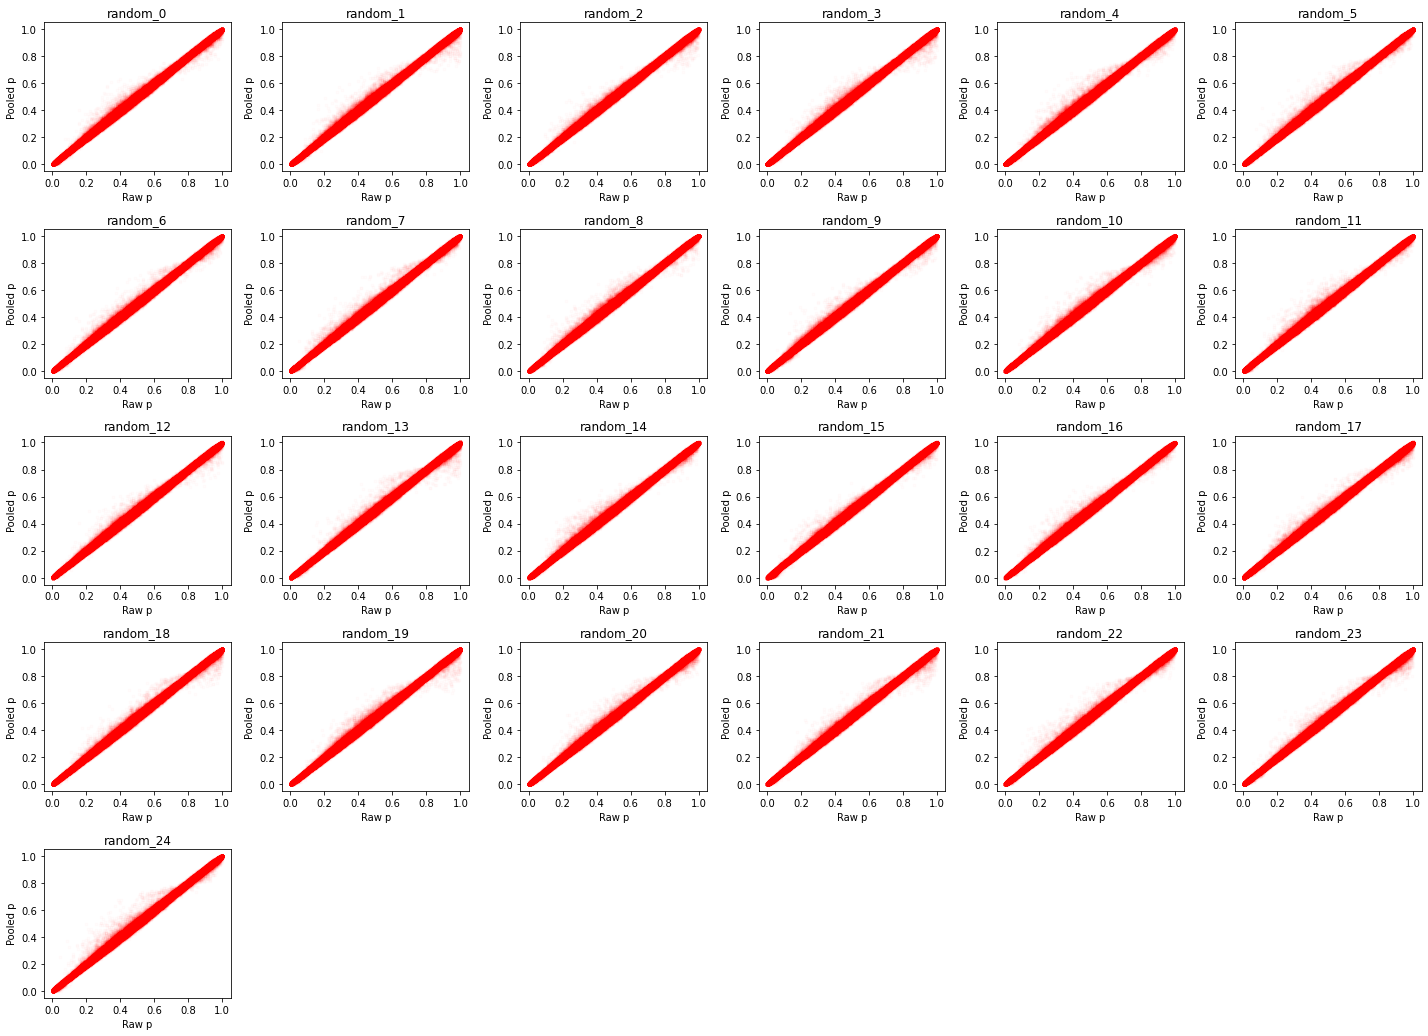

In [17]:
num_cols = 6

plt.figure(figsize=[20, 2+3*len(result_dict)/num_cols])

for name_i, name in enumerate(result_dict):
    plt.subplot(int(np.ceil(len(result_dict) / num_cols)), num_cols, name_i + 1)
    
    plt.plot(result_dict[name]['pval'], result_dict[name]['trait_ep'], 'r.', alpha=0.01)
    plt.xlabel('Raw p')
    plt.ylabel('Pooled p')
    plt.title(name)
plt.tight_layout()
plt.show()


## Bias in each tissue

## pval

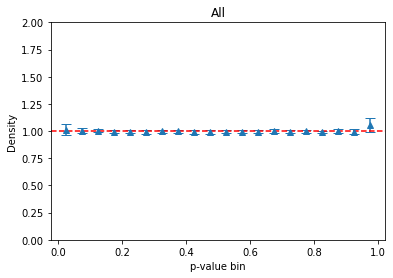

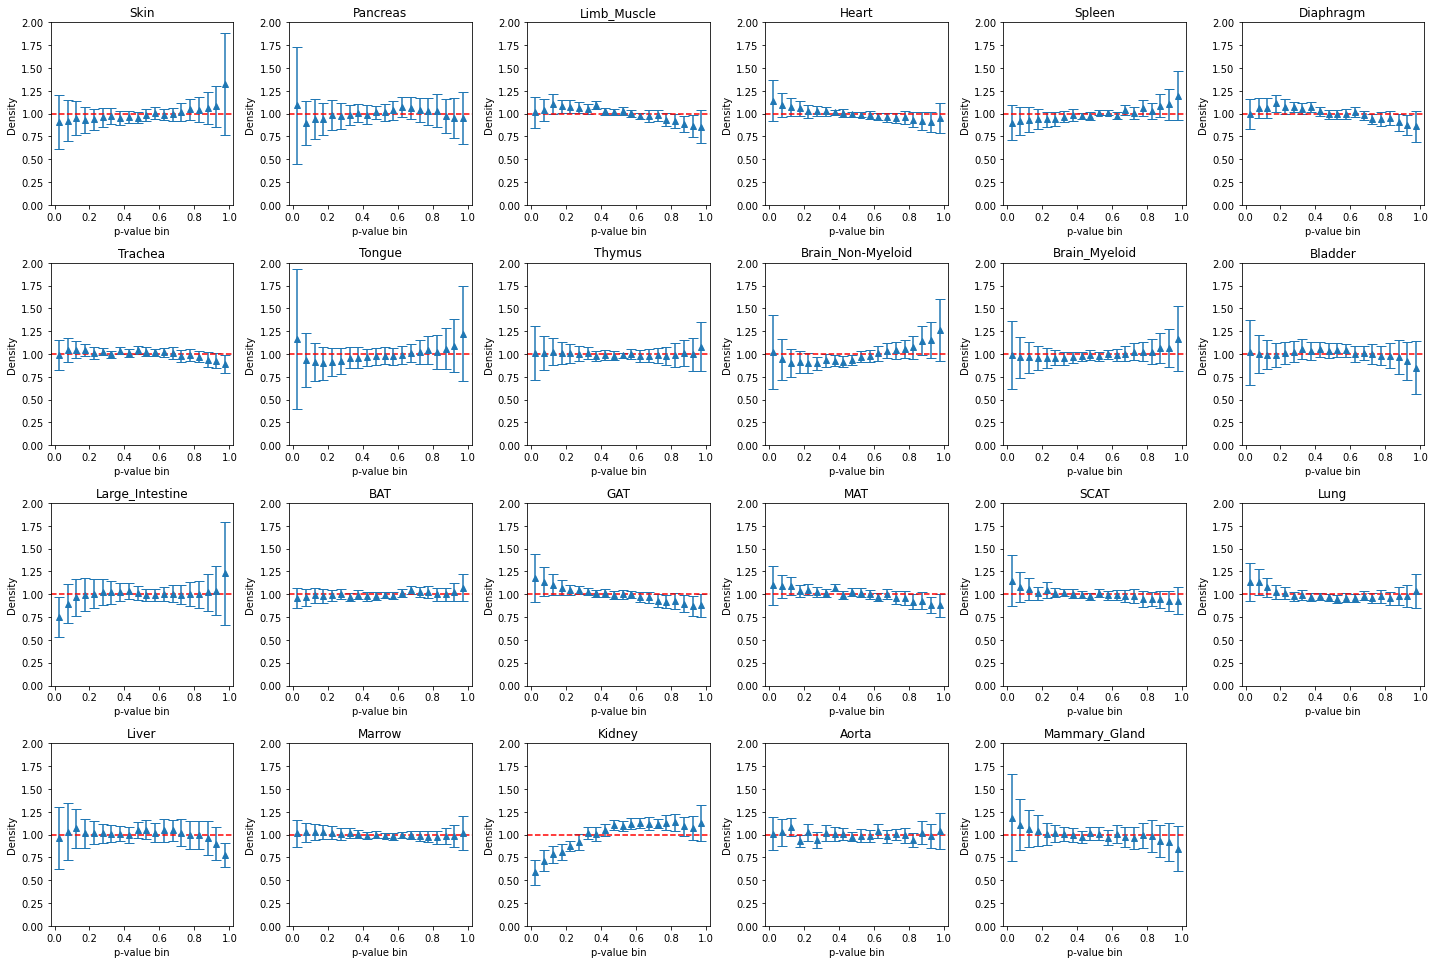

## trait_ep

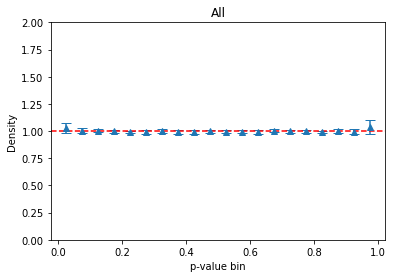

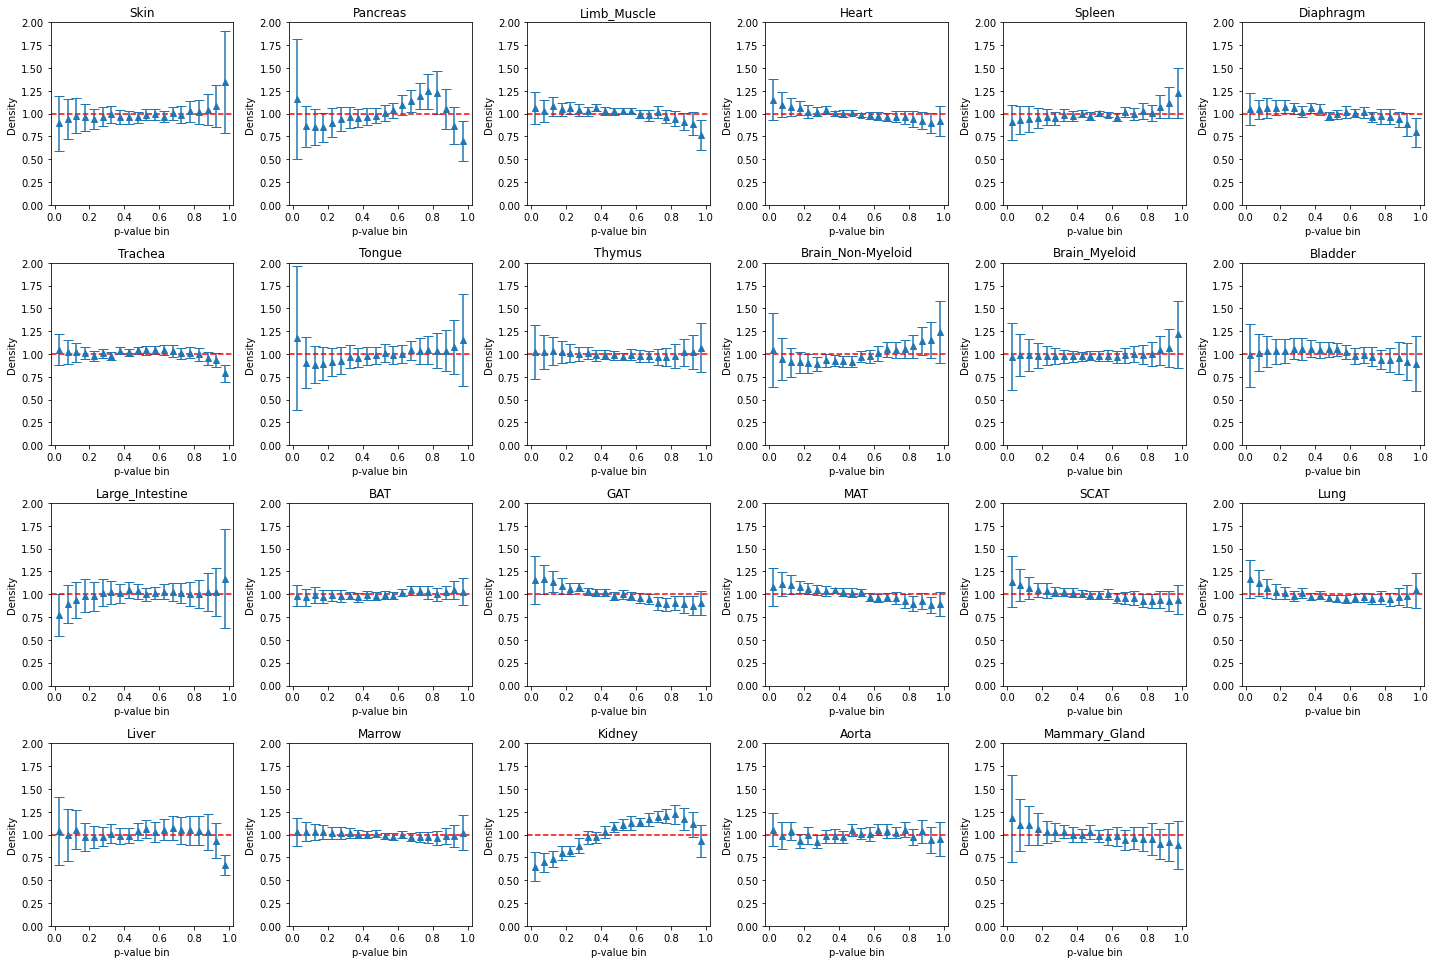

## normal_trait_ep

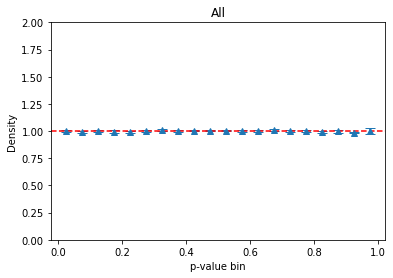

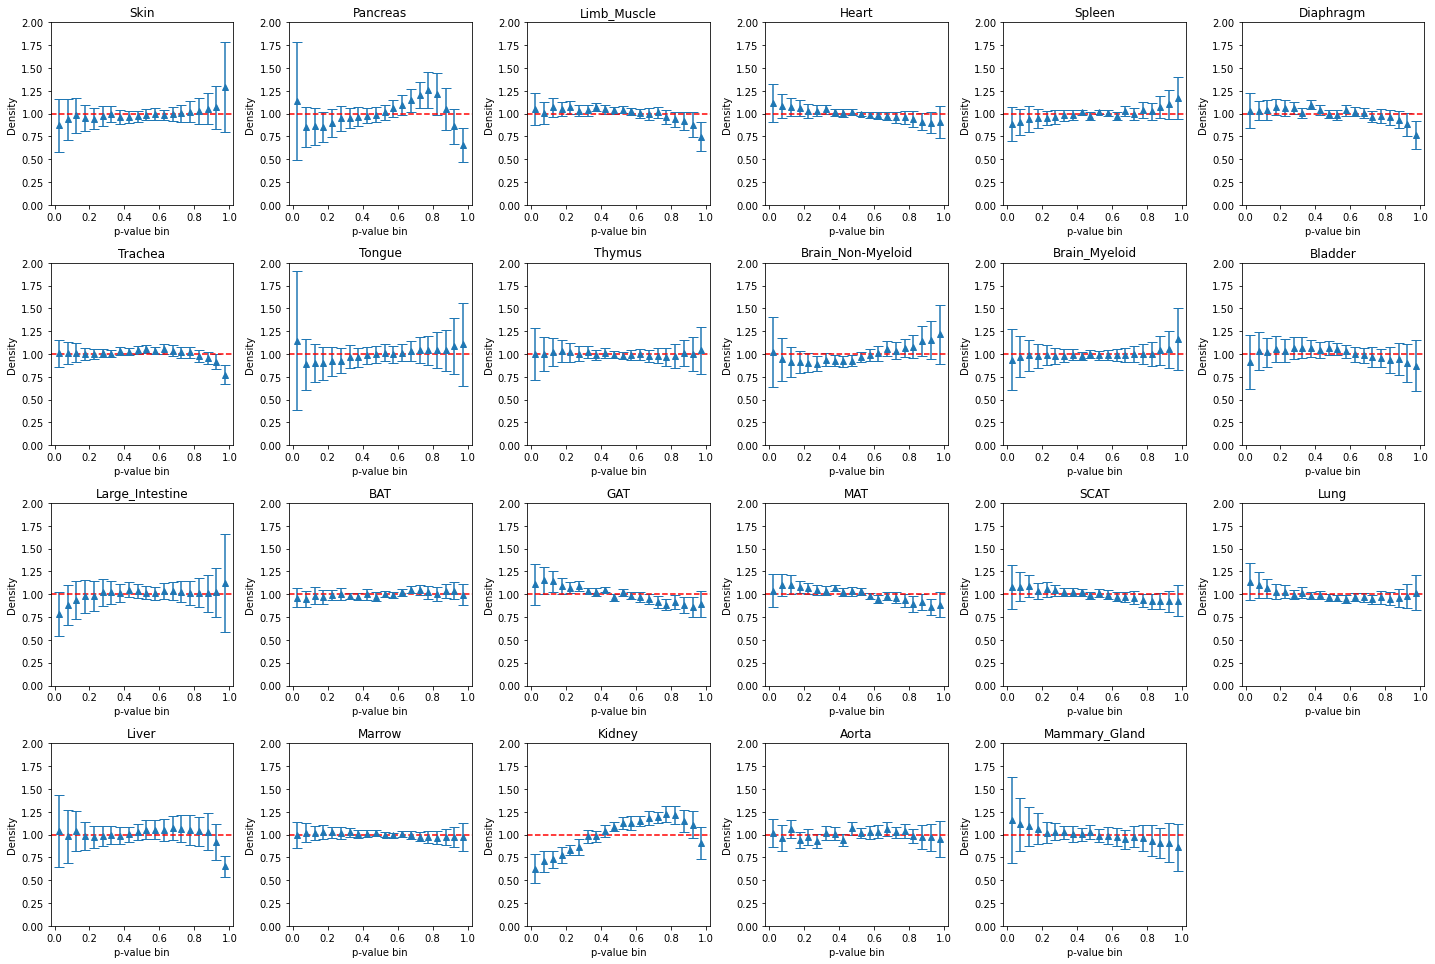

## robust_trait_ep

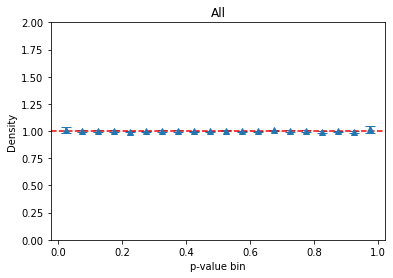

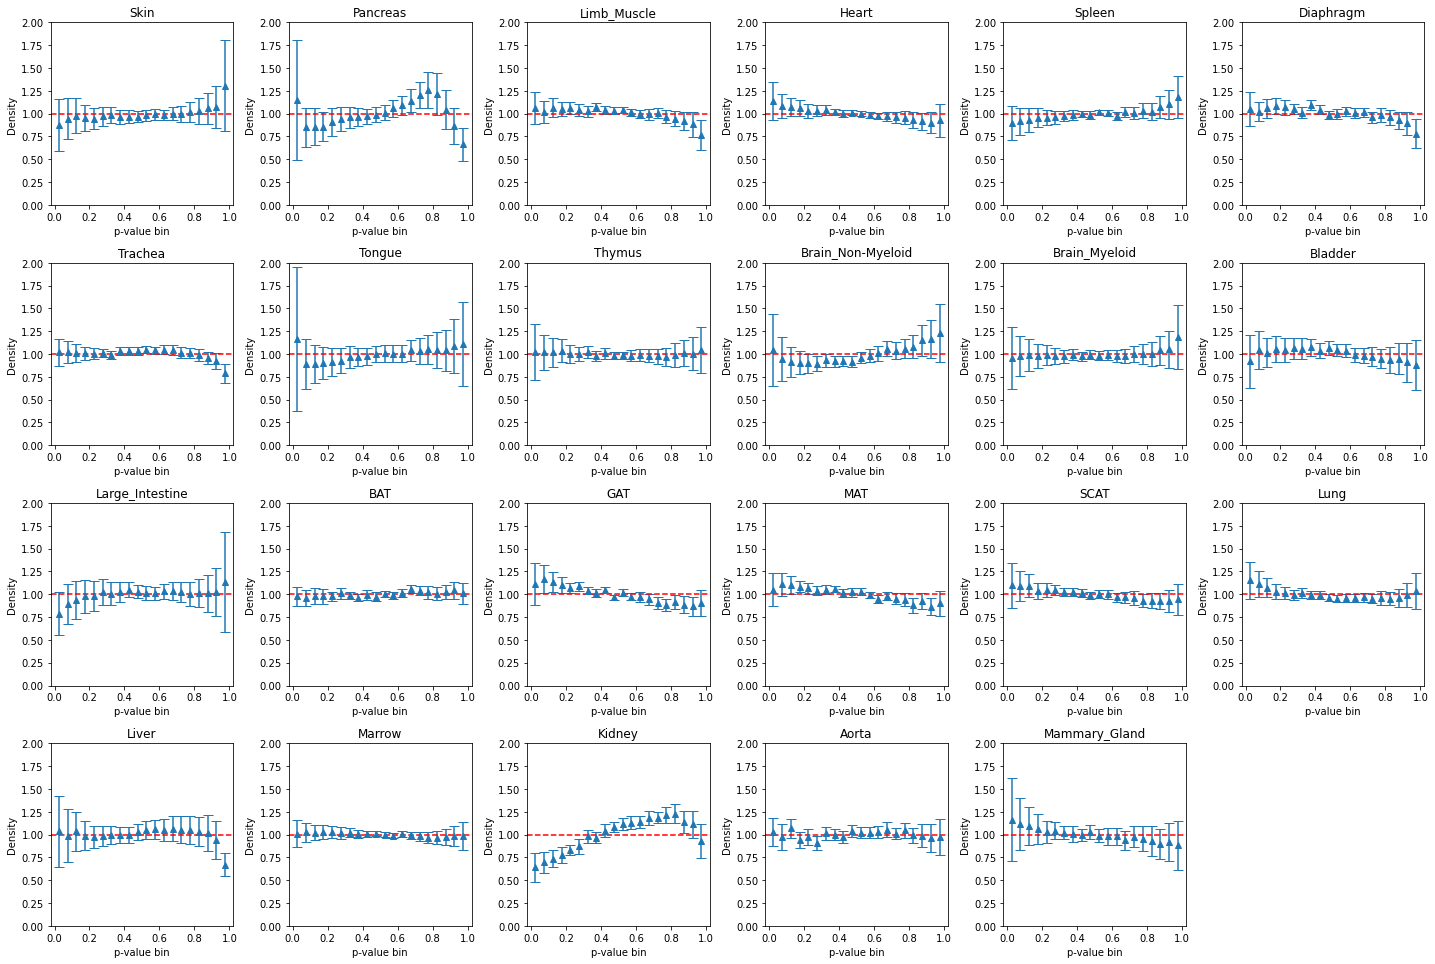

In [18]:
for trait_ep_name in ['pval', 'trait_ep', 'normal_trait_ep', 'robust_trait_ep']:
    display(Markdown(f'## {trait_ep_name}'))
    
    tissue_df = data_facs_ct[result_dict['random_0']['index']].obs.tissue
    num_bins=20
    hists = [np.histogram(result_dict[name][trait_ep_name], bins=num_bins, range=(0, 1), density=True)[0] for name in result_dict]
    plt.errorbar(np.arange(0, 1, 1 / num_bins) + 0.5 / num_bins, 
                 np.mean(hists, axis=0), 
                 np.std(hists, axis=0) * 2 / np.sqrt(num_sim), 
                 linestyle='None', marker='^', capsize=5)
    plt.ylim(0, 2)
    plt.axhline(y=1., linestyle='--', color='r')
    plt.xlabel('p-value bin')
    plt.ylabel('Density')
    plt.title('All')

    tissue_list = data_facs_ct.obs['tissue'].unique()
    plt.figure(figsize=[20, 2+3*len(tissue_list)/num_cols])
    for tissue_i, tissue in enumerate(tissue_list):
        tissue_index = (tissue_df == tissue)
        num_bins = 20
        plt.subplot(int(np.ceil(len(tissue_list) / num_cols)), num_cols, tissue_i + 1)
        hists = [np.histogram(result_dict[name][trait_ep_name][tissue_index], bins=num_bins, range=(0, 1), density=True)[0] for name in result_dict]
        plt.errorbar(np.arange(0, 1, 1 / num_bins) + 0.5 / num_bins, 
                     np.mean(hists, axis=0), 
                     np.std(hists, axis=0) * 2 / np.sqrt(num_sim), 
                     linestyle='None', marker='^', capsize=5)
        plt.ylim(0, 2)
        plt.axhline(y=1., linestyle='--', color='r')
        plt.xlabel('p-value bin')
        plt.ylabel('Density')
        plt.title(tissue)
    plt.tight_layout()
    plt.show()


## p-value calibration

## trait_ep

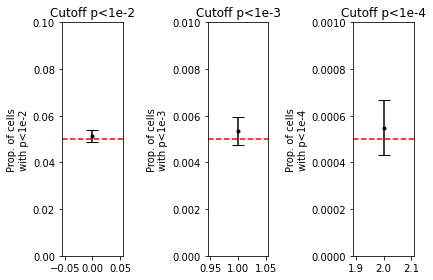

## normal_trait_ep

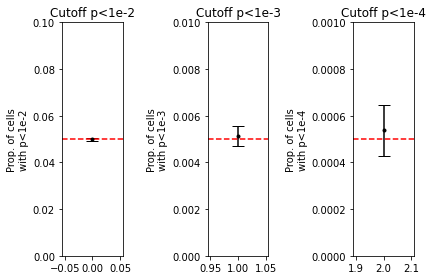

## robust_trait_ep

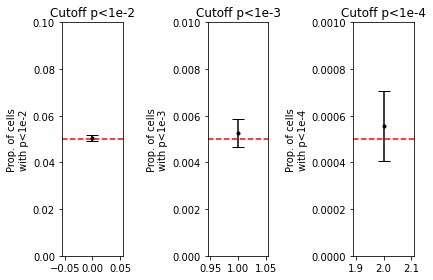

In [19]:
for trait_ep_name in ['trait_ep', 'normal_trait_ep', 'robust_trait_ep']:
    display(Markdown(f'## {trait_ep_name}'))

    trait_ep_list = [result_dict[name][trait_ep_name] for name in result_dict]
    plt.figure()

    for cutoff_i, cutoff in enumerate([2, 3, 4]):
        plt.subplot(1, 3, cutoff_i + 1)
        thres = 5 * 10 ** (-cutoff)
        sig_prop_list = [np.mean(trait_ep < thres) for trait_ep in trait_ep_list]

        plt.errorbar(cutoff_i, np.mean(sig_prop_list),
                 yerr=2 * np.std(sig_prop_list) / np.sqrt(len(sig_prop_list)) ,
                 color='k', fmt='.', capsize=6)
        plt.ylim(0, thres * 2)
        plt.axhline(thres, linestyle='--', color='r', )
        plt.title(f'Cutoff p<1e-{cutoff}')
        plt.ylabel(f'Prop. of cells\nwith p<1e-{cutoff}')
    plt.tight_layout()
    plt.show()

# Real data analysis

In [20]:
def load_gene_score(path, gene_id_col, score_col, ascending=True, num_genes=None, hsapiens_mmusculus_mapping=None):
    """load gene score from file and sort 
    Args:
        path: the file path to the gene score, in csv format
        gene_id_col: the column corresponding the gene identifier
        score_col: the column corresponding to the gene score
        ascending: whether to rank genes by score in ascending order
        convert_mmusculus: whether to convert to mmusculus gene symbols, input a dataframe if needed
        
    Returns:
        gene_score (pd.DataFrame): a dataframe with sorted scores
    """
    df = pd.read_csv(path, usecols=[gene_id_col, score_col])
    df.columns =['GENE', 'SCORE']
    if hsapiens_mmusculus_mapping is not None:
        df = pd.merge(df, hsapiens_mmusculus_mapping, left_on='GENE', right_on='hsapiens')[['mmusculus', 'SCORE']].rename(columns={'mmusculus': 'GENE'})
    df = df.sort_values('SCORE', ascending=ascending)
    if num_genes is not None:
        df = df.iloc[0 : num_genes, :].reset_index(drop=True)
    return df

def zsc2pval(zsc):
    return 1 - sp.stats.norm.cdf(zsc)


In [21]:
np.random.seed(1234)
gene_set_dict = dict()

## generate gene sets
trait_list = ['PASS_Schizophrenia_Ruderfer2018',
              'PASS_BipolarDisorder_Ruderfer2018',
              'PASS_Alzheimers_Jansen2019', 
              'PASS_AdultOnsetAsthma_Ferreira2019',
              'PASS_Coronary_Artery_Disease', 
              'PASS_LargeArteryStroke_Malik2018', 
              'PASS_HDL', 'PASS_LDL',
              'PASS_Rheumatoid_Arthritis', 'PASS_Lupus', 
              'PASS_IBD_deLange2017', 
              'PASS_Type_1_Diabetes', 
              'PASS_Type_2_Diabetes']

for trait in trait_list:
    # trait gene set
    trait_gene_df = load_gene_score(path=join(GENE_SCORE_PATH, 'gwas_max_abs_z', f'{trait}.csv'),
                     gene_id_col='GENE',
                     score_col='MAX_ABS_Z',
                     ascending=False,
                     num_genes=500,
                     hsapiens_mmusculus_mapping=hsapiens_mmusculus_mapping)

    gene_set_dict[trait] = np.unique(trait_gene_df.GENE.values)

for i in range(1, 6):
    gene_set_dict[f'random_{i}'] = np.unique(list(np.random.choice(data_facs_ct.var_names, size=500, replace=False)))

for name in gene_set_dict:
    gene_set_dict[name] = list(set(gene_set_dict[name]) & set(data_facs_ct.var_names))

In [22]:
import submitit
executor = submitit.AutoExecutor(folder="~/submitit_log/")
executor.update_parameters(timeout_min=25, mem_gb=20, slurm_partition="shared")
job_dict = {name: executor.submit(demo, 'all', 'all', 'own', gene_set_dict[name]) for name in gene_set_dict}

In [27]:
job_dict

{'PASS_Schizophrenia_Ruderfer2018': SlurmJob<job_id=10049968, task_id=0, state="COMPLETED">,
 'PASS_BipolarDisorder_Ruderfer2018': SlurmJob<job_id=10049969, task_id=0, state="COMPLETED">,
 'PASS_Alzheimers_Jansen2019': SlurmJob<job_id=10049970, task_id=0, state="COMPLETED">,
 'PASS_AdultOnsetAsthma_Ferreira2019': SlurmJob<job_id=10049971, task_id=0, state="COMPLETED">,
 'PASS_Coronary_Artery_Disease': SlurmJob<job_id=10049972, task_id=0, state="COMPLETED">,
 'PASS_LargeArteryStroke_Malik2018': SlurmJob<job_id=10049973, task_id=0, state="COMPLETED">,
 'PASS_HDL': SlurmJob<job_id=10049974, task_id=0, state="COMPLETED">,
 'PASS_LDL': SlurmJob<job_id=10049975, task_id=0, state="COMPLETED">,
 'PASS_Rheumatoid_Arthritis': SlurmJob<job_id=10049977, task_id=0, state="COMPLETED">,
 'PASS_Lupus': SlurmJob<job_id=10049979, task_id=0, state="COMPLETED">,
 'PASS_IBD_deLange2017': SlurmJob<job_id=10049980, task_id=0, state="COMPLETED">,
 'PASS_Type_1_Diabetes': SlurmJob<job_id=10049983, task_id=0, s

# trait_ep

# PASS_Schizophrenia_Ruderfer2018          n_rej=292
# PASS_BipolarDisorder_Ruderfer2018        n_rej=4
# PASS_Alzheimers_Jansen2019               n_rej=0
# PASS_AdultOnsetAsthma_Ferreira2019       n_rej=1215
# PASS_Coronary_Artery_Disease             n_rej=0
# PASS_LargeArteryStroke_Malik2018         n_rej=2
# PASS_HDL                                 n_rej=746
# PASS_LDL                                 n_rej=276
# PASS_Rheumatoid_Arthritis                n_rej=4421
# PASS_Lupus                               n_rej=174
# PASS_IBD_deLange2017                     n_rej=4824
# PASS_Type_1_Diabetes                     n_rej=11
# PASS_Type_2_Diabetes                     n_rej=44
# random_1                                 n_rej=0
# random_2                                 n_rej=0
# random_3                                 n_rej=0
# random_4                                 n_rej=0
# random_5                                 n_rej=0


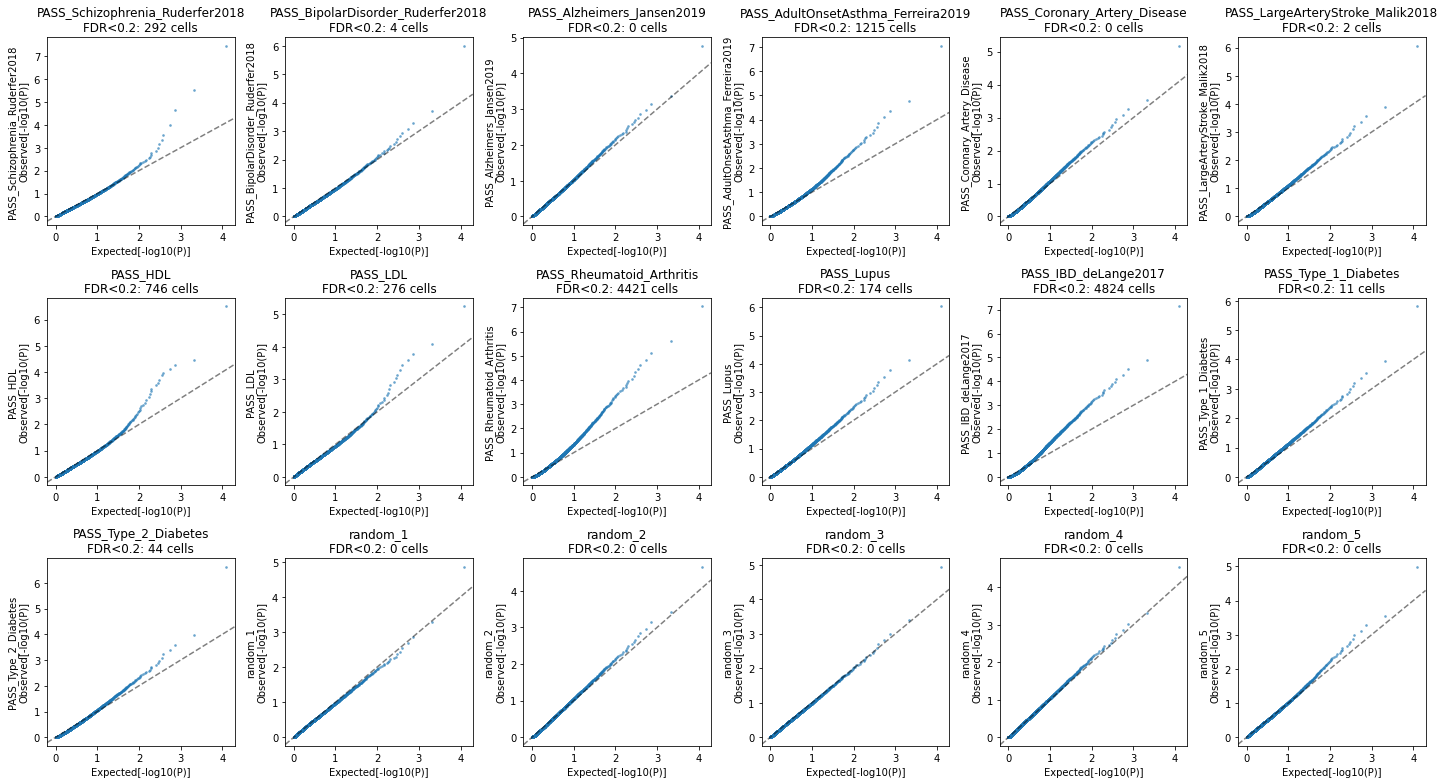

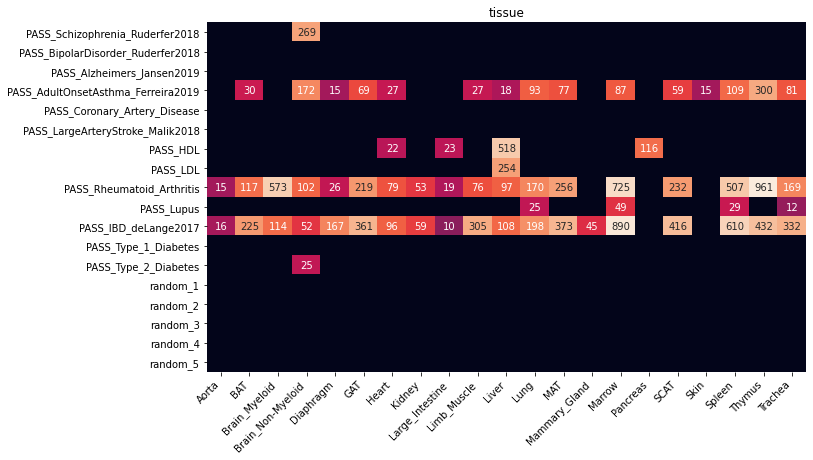

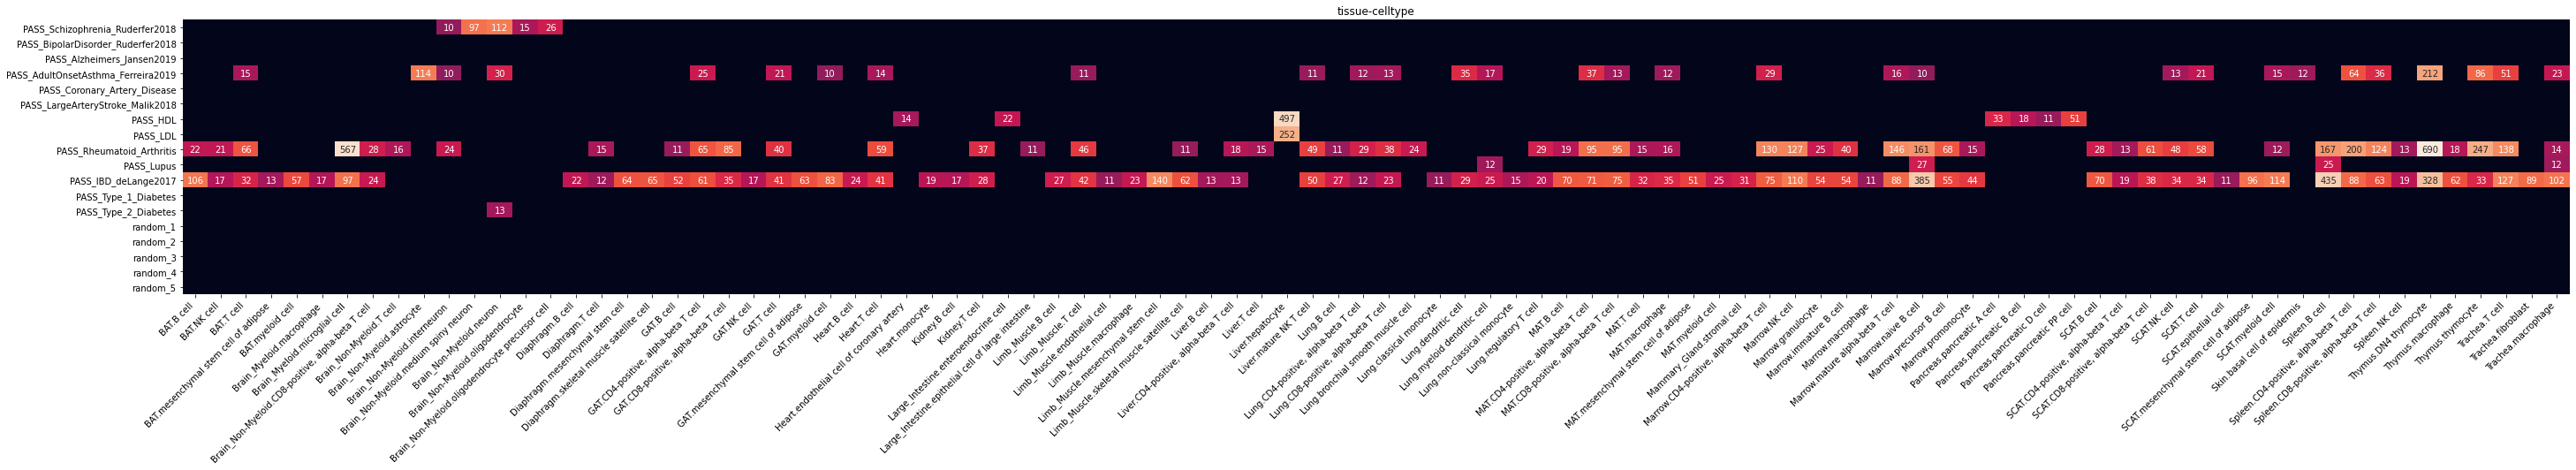

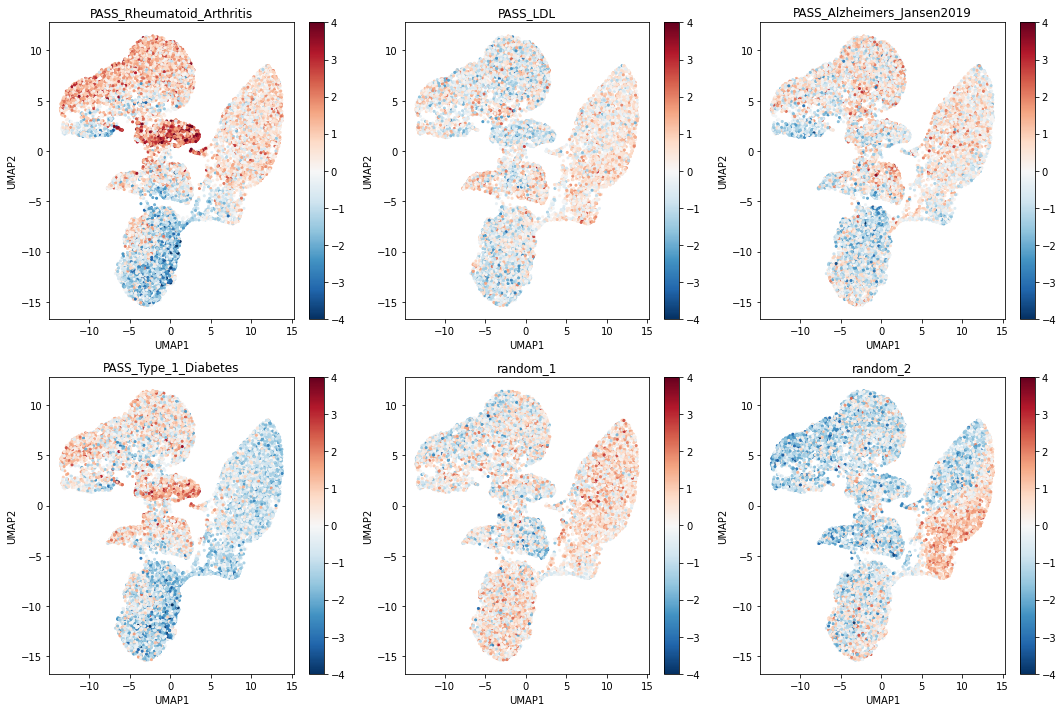

# normal_trait_ep

# PASS_Schizophrenia_Ruderfer2018          n_rej=242
# PASS_BipolarDisorder_Ruderfer2018        n_rej=4
# PASS_Alzheimers_Jansen2019               n_rej=0
# PASS_AdultOnsetAsthma_Ferreira2019       n_rej=32
# PASS_Coronary_Artery_Disease             n_rej=0
# PASS_LargeArteryStroke_Malik2018         n_rej=0
# PASS_HDL                                 n_rej=578
# PASS_LDL                                 n_rej=339
# PASS_Rheumatoid_Arthritis                n_rej=0
# PASS_Lupus                               n_rej=0
# PASS_IBD_deLange2017                     n_rej=0
# PASS_Type_1_Diabetes                     n_rej=0
# PASS_Type_2_Diabetes                     n_rej=4
# random_1                                 n_rej=0
# random_2                                 n_rej=0
# random_3                                 n_rej=0
# random_4                                 n_rej=0
# random_5                                 n_rej=0


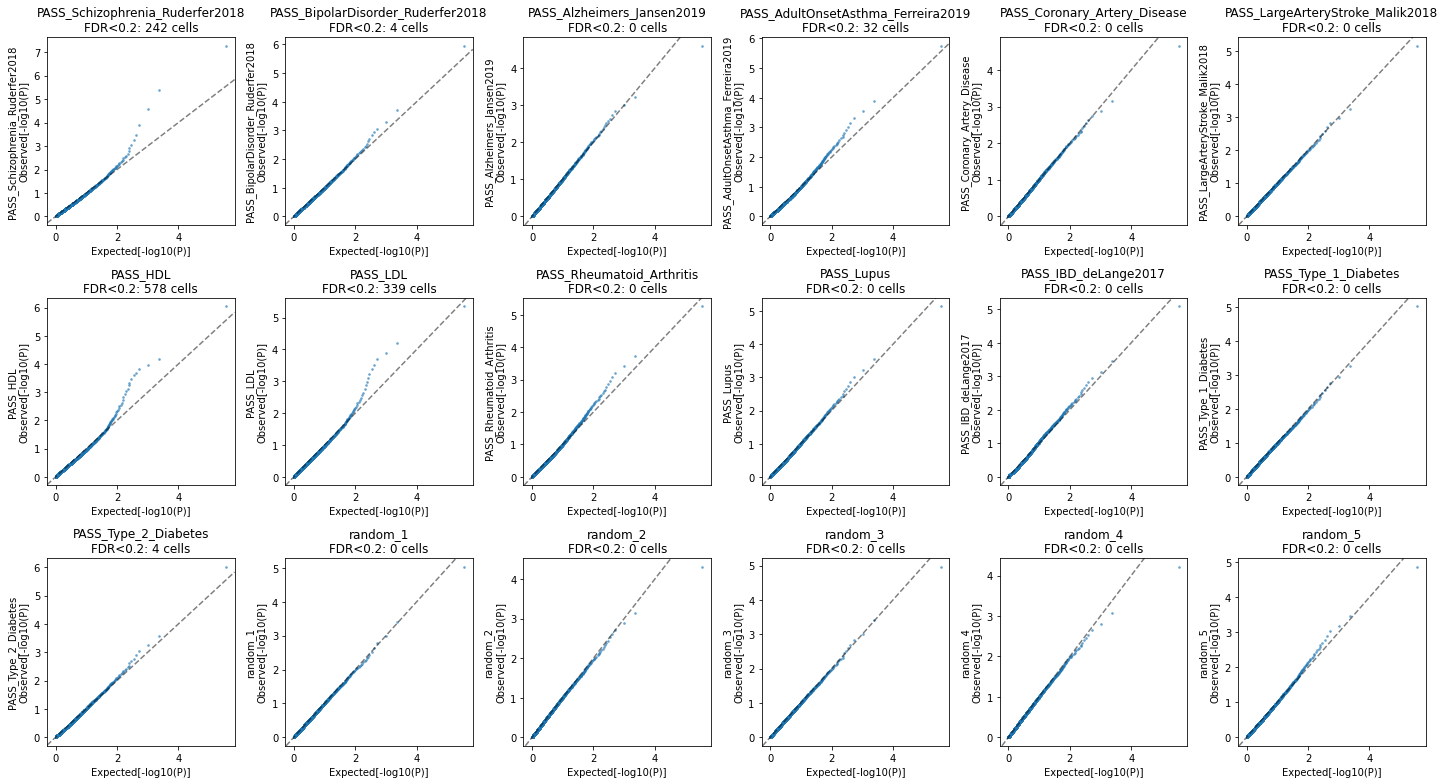

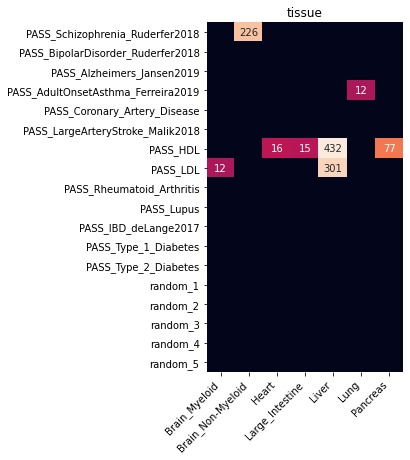

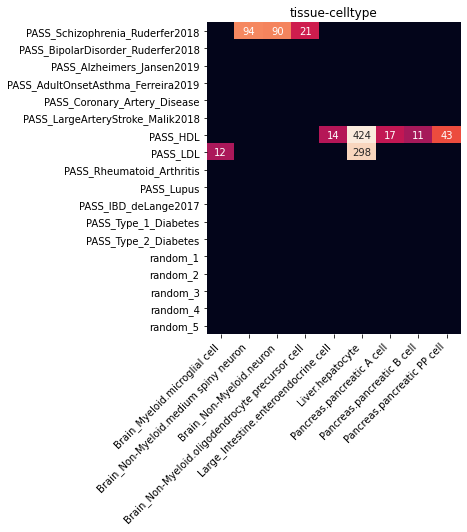

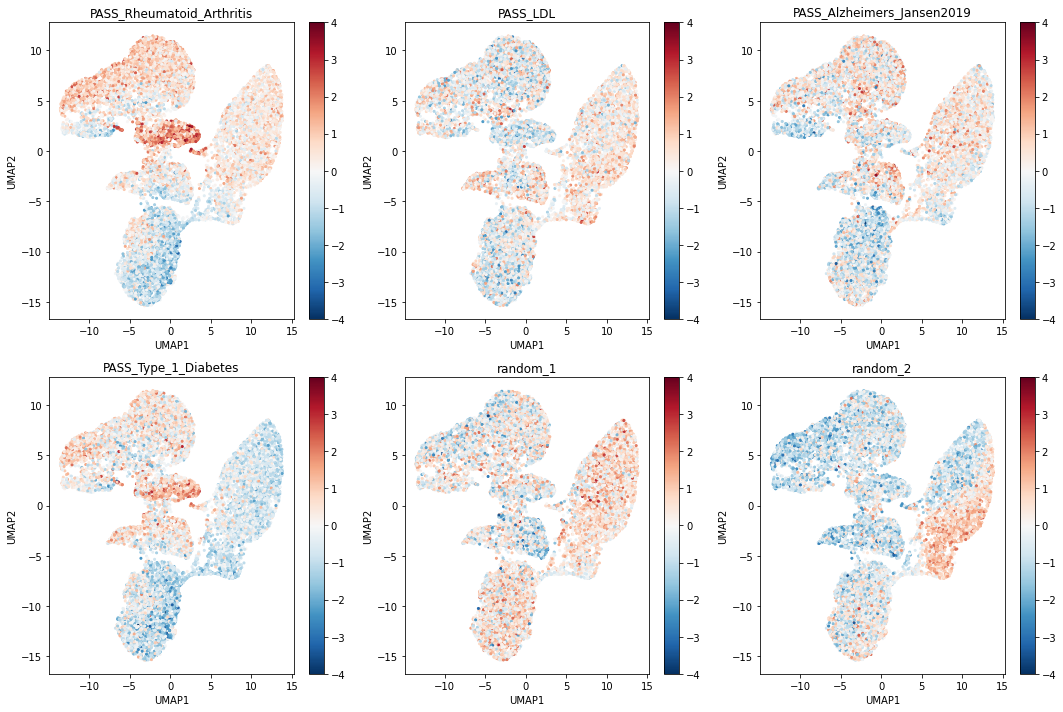

# robust_trait_ep

# PASS_Schizophrenia_Ruderfer2018          n_rej=318
# PASS_BipolarDisorder_Ruderfer2018        n_rej=4
# PASS_Alzheimers_Jansen2019               n_rej=0
# PASS_AdultOnsetAsthma_Ferreira2019       n_rej=179
# PASS_Coronary_Artery_Disease             n_rej=0
# PASS_LargeArteryStroke_Malik2018         n_rej=0
# PASS_HDL                                 n_rej=737
# PASS_LDL                                 n_rej=430
# PASS_Rheumatoid_Arthritis                n_rej=0
# PASS_Lupus                               n_rej=0
# PASS_IBD_deLange2017                     n_rej=0
# PASS_Type_1_Diabetes                     n_rej=0
# PASS_Type_2_Diabetes                     n_rej=4
# random_1                                 n_rej=0
# random_2                                 n_rej=0
# random_3                                 n_rej=0
# random_4                                 n_rej=0
# random_5                                 n_rej=0


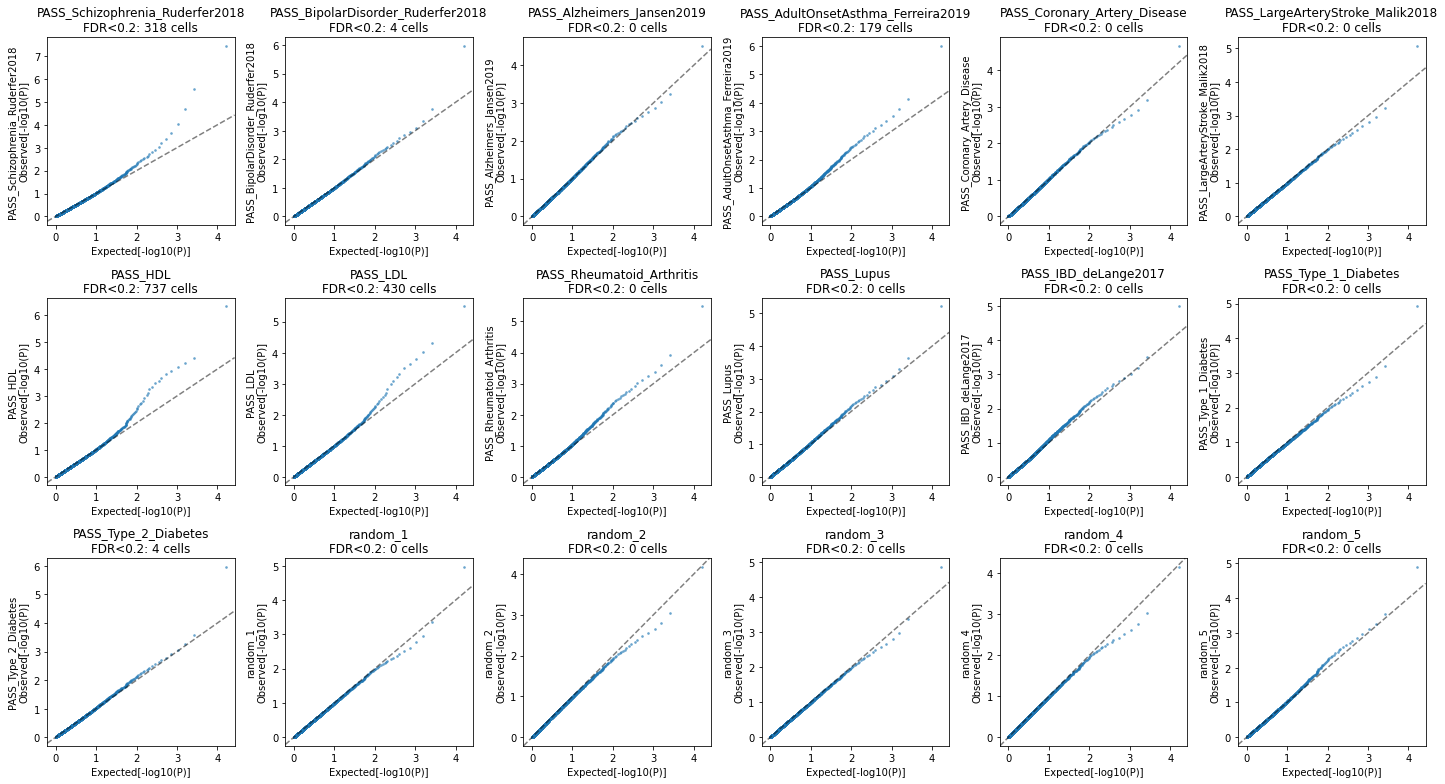

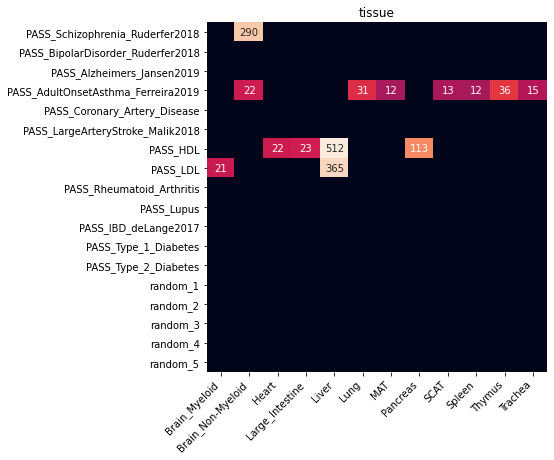

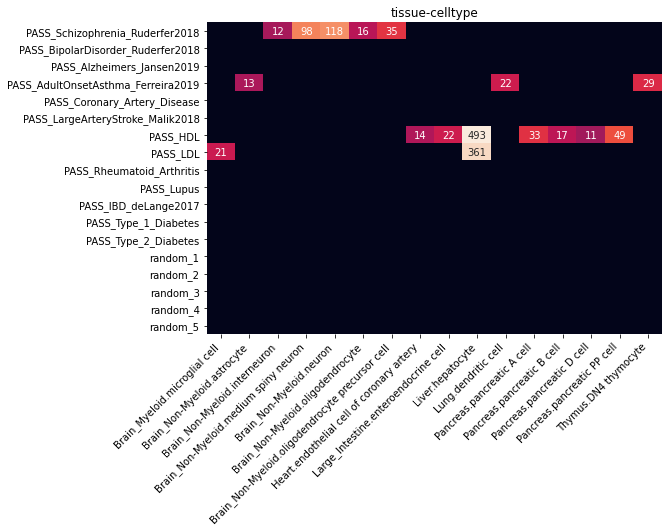

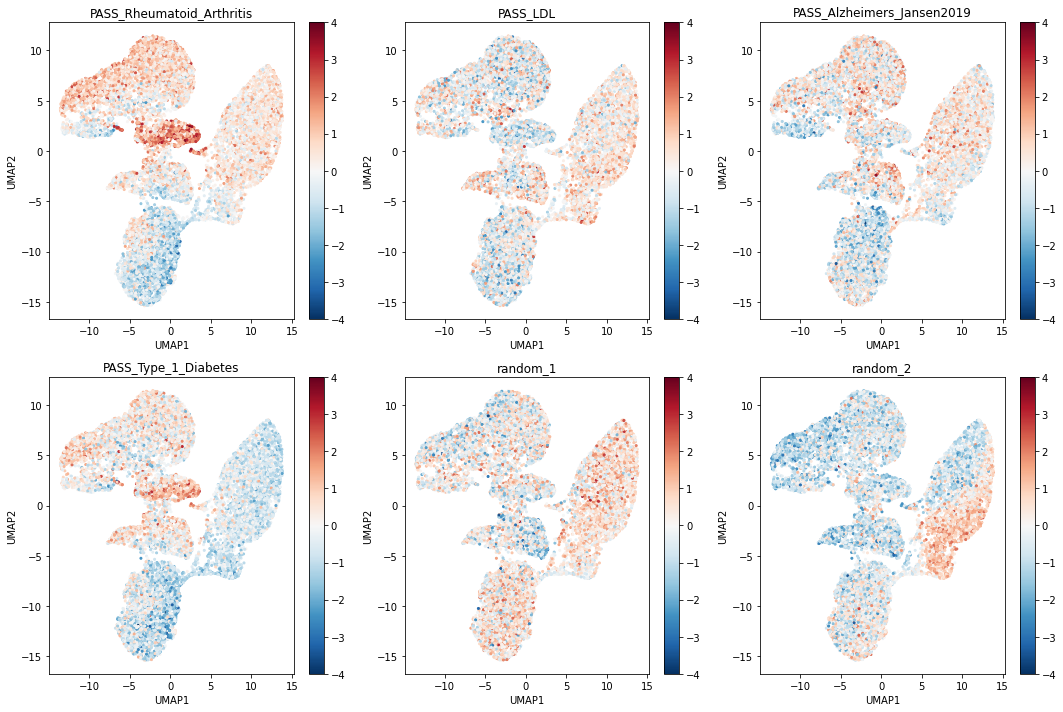

In [29]:
for trait_ep_name in ['trait_ep', 'normal_trait_ep', 'robust_trait_ep']:
    display(Markdown(f'# {trait_ep_name}'))

    # collect results and general summary
    trait_ep_dict = dict()
    trait_ez_dict = dict()
    trait_fdr_dict = dict()
    for trait in job_dict:
        if job_dict[trait].state != 'COMPLETED':
            continue
        trait_ep = job_dict[trait].result()[trait_ep_name]
        trait_ep_dict[trait] = trait_ep
        trait_ez = -sp.stats.norm.ppf(trait_ep).clip(min=-10,max=10)
        trait_ez_dict[trait] = trait_ez
        trait_fdr = multipletests(trait_ep, method='fdr_bh')[1]
        trait_fdr_dict[trait] = trait_fdr
        print('# %-40s n_rej=%d'%(trait, (trait_fdr<0.2).sum()))


    # qqplot
    plot_trait_list = list(trait_ep_dict.keys())

    num_cols = 6
    normal_x = np.random.rand(10000)
    normal_x = -np.log10(normal_x)

    plt.figure(figsize=[20, 2+3*len(plot_trait_list)/num_cols])
    for trait_i, trait in enumerate(plot_trait_list):

        trait_logep = -np.log10(trait_ep_dict[trait])
        plt.subplot(int(np.ceil(len(plot_trait_list) / num_cols)), num_cols, trait_i + 1)
        util.qqplot(x=normal_x, y=trait_logep, quantiles=2000, s=3, alpha=0.5)
        plt.axline((1, 1), slope=1, linestyle='--', color='k', alpha=0.5)

        plt.title('%s\nFDR<0.2: %d cells'%(trait,(trait_fdr_dict[trait]<0.2).sum()))
        plt.ylabel('%s\nObserved[-log10(P)]'%trait)
        plt.xlabel('Expected[-log10(P)]')
    plt.tight_layout()
    plt.show()


    # Find number of associated cells for each tissue/tissue_celltype
    trait_list = list(job_dict.keys())
    tissue_list = list(set(data_facs_ct.obs['tissue']))
    tissue_list.sort()
    tc_list = list(set(data_facs_ct.obs['tissue_celltype']))
    tc_list.sort()

    dic_assoc = {'tissue': pd.DataFrame(index=tissue_list, columns=trait_list, data=0),
                 'tissue-celltype': pd.DataFrame(index=tc_list, columns=trait_list, data=0)}

    df_obs = data_facs_ct.obs.copy()

    for trait in trait_ep_dict:

        v_p = trait_ep_dict[trait]
        v_fdr = multipletests(v_p, method='fdr_bh')[1]

        # tissue
        temp_df = df_obs.loc[v_fdr<0.2].copy()
        temp_df = temp_df.groupby(['tissue']).agg({'cell':len})
        temp_df = temp_df.loc[~temp_df['cell'].isna()]
        dic_assoc['tissue'].loc[temp_df.index, trait] = temp_df['cell'].values

        # tissue-cell
        temp_df = df_obs.loc[v_fdr<0.2].copy().copy()
        temp_df = temp_df.groupby(['tissue_celltype']).agg({'cell':len})
        temp_df = temp_df.loc[~temp_df['cell'].isna()]
        dic_assoc['tissue-celltype'].loc[temp_df.index, trait] = temp_df['cell'].values

    # Plot the results table    
    def num2str(x):
        if x>1000:
            return '%0.1fk'%(x/1000)
        elif x>0:
            return '%d'%x
        else:
            return ''

    for term in dic_assoc.keys():

        df_plot = dic_assoc[term].copy()
        df_plot = df_plot.loc[df_plot.max(axis=1)>10]
        df_plot = df_plot.T
        df_plot[df_plot<10] = 0

        mat_annot = np.zeros(df_plot.shape, dtype=object)
        for i_col,col in enumerate(df_plot.columns):
            mat_annot[:,i_col] = [num2str(x) for x in df_plot[col].values]
        df_plot = np.log10(df_plot+1)

        plt.figure(figsize=[0.4*df_plot.shape[1]+3, 0.25*df_plot.shape[0]+2+1*('tissue-celltype' in term)])
        sns.heatmap(df_plot, annot=mat_annot, fmt='s', cbar=False)
        plt.xticks(np.arange(df_plot.shape[1])+0.5, df_plot.columns, rotation=45, ha='right')
        plt.title(term)
        plt.tight_layout()
        plt.show()


    # plot UMAP examples
    plot_list = [['Marrow', 
                  ['PASS_Rheumatoid_Arthritis', 'PASS_LDL', 'PASS_Alzheimers_Jansen2019',  'PASS_Type_1_Diabetes', 'random_1', 'random_2',]]]

    for tissue, trait_plot_list in plot_list:

        adata_small = dic_data_facs[tissue].copy()    
        df_plot = pd.DataFrame(index=adata_small.obs.index)
        df_plot['UMAP1'] = adata_small.obsm['X_umap'][:,0]
        df_plot['UMAP2'] = adata_small.obsm['X_umap'][:,1]

        # Trait TRS plot
        plt.figure(figsize=[15,10])
        for i_trait,trait in enumerate(trait_plot_list):

            plt.subplot(2,3,i_trait+1)
            temp_df = pd.DataFrame(index=data_facs_ct.obs.index)
            temp_df[trait] = trait_ez_dict[trait]
            df_plot = df_plot.join(temp_df[trait])


            max_ = np.quantile(np.absolute(df_plot[trait].values), 0.99)
            min_ = np.quantile(np.absolute(df_plot[trait].values), 0.01)
            plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[trait],
                        cmap='RdBu_r', vmax=max_, vmin=-max_, s=4)
            plt.colorbar()
            plt.clim(-4,4)
            plt.xlabel('UMAP1')
            plt.ylabel('UMAP2')
            plt.title('%s'%trait)

        plt.tight_layout()
        plt.show()